In [1]:
import crocoddyl
import pinocchio
from IPython.display import HTML
import mim_solvers
import numpy as np
from matplotlib import animation
from matplotlib import pyplot as plt
from PointMass_utils import *
from PointMass_model import DifferentialActionModelPointMass

In [2]:
nx = 4
nu = 2
T = 50
start_point = np.array([0, 0, 0, 0])
target_low = np.array([10, 0, 0, 0])
target_high = np.array([10, 10, 0, 0])
obs0 = Obstacle(5, 5, 2, 'Obs0')
obs1 = Obstacle(3.5, 3.5, 1, 'Obs1')
obs2 = Obstacle(6.5, 6.5, 1, 'Obs2')
obs3 = Obstacle(6.5, 3.5, 1, 'Obs3')
# obs_set = [obs1, obs2, obs3]
obs_set = [obs0]
translation_cost = XReg(nx, target_high, 'trans_high')
xreg = XReg(nx, start_point, 'XReg')
ureg = UReg(nu, None, 'UReg')

cost_set = Costs()
cost_set.add_cost(translation_cost)
# cost_set.add_cost(xreg)
cost_set.add_cost(ureg)
cost_set.add_cost(obs0)
# cost_set.add_cost(obs1)
# cost_set.add_cost(obs2)
# cost_set.add_cost(obs3)

nr = cost_set.nr

In [3]:
# Desired Running and Terminal Model
w_run = np.array([10, 1., 800])
w_term = np.array([1000, 1., 800])
# w_des = (np.hstack([w_run, w_term])/(np.max(np.hstack([w_run, w_term])))).copy()
w_des = (np.hstack([w_run, w_term])/(np.linalg.norm(np.hstack([w_run, w_term])))).copy()
w_run = w_des[:nr]; w_term = w_des[nr:]
PM_DAM_running = DifferentialActionModelPointMass(cost_set, w_run)
PM_DAM_terminal = DifferentialActionModelPointMass(cost_set, w_term)
pmDataRunning = PM_DAM_running.createData()
pmDataTerminal = PM_DAM_terminal.createData()
PM_ND_R = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_running, False)
PM_ND_T = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_terminal, False)
timeStep = 5e-2
PM_IAM = crocoddyl.IntegratedActionModelEuler(PM_ND_R, timeStep)
PM_IAM_T = crocoddyl.IntegratedActionModelEuler(PM_ND_T, 0.0)
x0 = np.array([0.0, 0.0, 0.0, 0.0])
u0 = np.array([0.0, 0.0])
problem = crocoddyl.ShootingProblem(x0, [PM_IAM] * T, PM_IAM_T)
# Creating the SQP solver
sqp_opt = mim_solvers.SolverSQP(problem)
sqp_opt.setCallbacks([crocoddyl.CallbackVerbose()])
sqp_opt.with_callbacks=True
sqp_opt.termination_tolerance = 1e-5
xs_init = [x0 for i in range(T+1)]
us_init = [u0 for i in range(T)]

# Solving this problem
done = sqp_opt.solve(xs_init, us_init, 500)
xs_optimal = np.stack(sqp_opt.xs.tolist().copy())
us_optimal = np.stack(sqp_opt.us.tolist().copy())
print(done)

iter     merit         cost         grad      step    ||gaps||        KKT
   1  6.78808e+01  6.78808e+01  2.98523e+01  1.0000  0.00000e+00  6.60350e+00
   2  2.68987e+00  2.68987e+00  1.16656e-01  1.0000  2.39808e-14  4.20158e-02
   3  2.66932e+00  2.66932e+00  8.92492e-02  1.0000  1.81519e-10  2.84314e-02
   4  2.65771e+00  2.65771e+00  7.06710e-02  1.0000  1.07850e-10  1.96304e-02
   5  2.65044e+00  2.65044e+00  5.76998e-02  1.0000  1.03373e-10  1.37856e-02
   6  2.64532e+00  2.64532e+00  4.87032e-02  1.0000  1.19229e-10  9.82109e-03
   7  2.64132e+00  2.64132e+00  4.34615e-02  1.0000  9.21666e-11  7.08532e-03
   8  2.63790e+00  2.63790e+00  4.03832e-02  1.0000  1.03844e-10  5.17092e-03
   9  2.63481e+00  2.63481e+00  3.84733e-02  1.0000  8.91172e-11  3.81583e-03
  10  2.63190e+00  2.63190e+00  3.71850e-02  1.0000  9.73056e-11  3.27212e-03
iter     merit         cost         grad      step    ||gaps||        KKT
  11  2.62910e+00  2.62910e+00  3.63315e-02  1.0000  8.25230e-11  3.3036

In [4]:
# HTML(animatePointMass(xs_optimal, obs_set, target_high).to_jshtml())

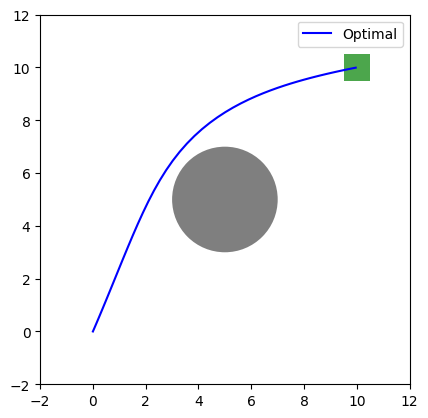

In [5]:
plot_1_traj(xs_optimal, obs_set, target_high, label='Optimal', linemap = 'b')

In [6]:
# Bad Running and Terminal Model
w_run = np.array([10, 1., 0])
w_term = np.array([1000, 1., 0])
# w_bad = (np.hstack([w_run, w_term])/(np.max(np.hstack([w_run, w_term])))).copy()
w_bad = (np.hstack([w_run, w_term])/(np.linalg.norm(np.hstack([w_run, w_term])))).copy()
w_run = w_bad[:nr]; w_term = w_bad[nr:]
PM_DAM_running = DifferentialActionModelPointMass(cost_set, w_run)
PM_DAM_terminal = DifferentialActionModelPointMass(cost_set, w_term)
pmDataRunning = PM_DAM_running.createData()
pmDataTerminal = PM_DAM_terminal.createData()
PM_ND_R = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_running, False)
PM_ND_T = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_terminal, False)
timeStep = 5e-2
PM_IAM = crocoddyl.IntegratedActionModelEuler(PM_ND_R, timeStep)
PM_IAM_T = crocoddyl.IntegratedActionModelEuler(PM_ND_T, 0.0)
x0 = np.array([0.0, 0.0, 0.0, 0.0])
u0 = np.array([0.0, 0.0])
problem = crocoddyl.ShootingProblem(x0, [PM_IAM] * T, PM_IAM_T)
# Creating the SQP solver
sqp_non_opt = mim_solvers.SolverSQP(problem)
sqp_non_opt.setCallbacks([crocoddyl.CallbackVerbose()])
sqp_non_opt.with_callbacks=True
sqp_non_opt.termination_tolerance = 1e-5
xs_init = [x0 for i in range(T+1)]
us_init = [u0 for i in range(T)]

# Solving this problem
done = sqp_non_opt.solve(xs_init, us_init, 500)
xs_non_optimal = np.stack(sqp_non_opt.xs.tolist().copy())
us_non_optimal = np.stack(sqp_non_opt.us.tolist().copy())
print(done)


iter     merit         cost         grad      step    ||gaps||        KKT
   1  1.02495e+02  1.02495e+02  2.98913e+01  1.0000  0.00000e+00  9.97135e+00
 END  1.32015e+00  1.32015e+00  1.23060e-04   ----   1.50158e-14  1.56166e-06
True


In [7]:
# HTML(animatePointMass(xs_non_optimal, obs_set, target_high).to_jshtml())

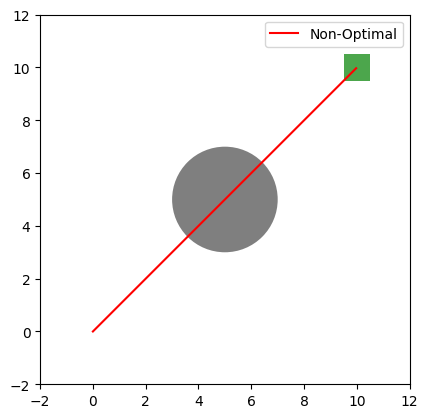

In [8]:
plot_1_traj(xs_non_optimal, obs_set, target_high, label='Non-Optimal', linemap = 'r')

In [9]:
print('Desired Trajectory Cost:  ', cost_set.traj_cost(xs_optimal, us_optimal, w_des[:nr], w_des[nr:], timeStep), ' || other Trajectory, same cost:   ', cost_set.traj_cost(xs_non_optimal, us_non_optimal, w_des[:nr], w_des[nr:], timeStep))
print('Bad Trajectory Cost:      ', cost_set.traj_cost(xs_non_optimal, us_non_optimal, w_bad[:nr], w_bad[nr:], timeStep), ' || other Trajectory, same cost:   ', cost_set.traj_cost(xs_optimal, us_optimal, w_bad[:nr], w_bad[nr:], timeStep))

Desired Trajectory Cost:   0.419065442374472  || other Trajectory, same cost:    1.196167708680359
Bad Trajectory Cost:       0.27442979894448283  || other Trajectory, same cost:    0.2973742907278293


In [10]:
###### IRL #######

In [11]:
# generating bad trajectories
num_bad = 15
xs_non_optimal_set = []
us_non_optimal_set = []
xs_non_optimal_set.append(np.stack(xs_non_optimal.tolist()).copy())
us_non_optimal_set.append(np.stack(us_non_optimal.tolist()).copy())
for _ in range(num_bad):
    Us = us_non_optimal.copy()+np.random.normal(0,0.2,np.stack(us_non_optimal.tolist()).shape)
    Xs = xs_non_optimal.copy()+np.random.normal(0,0.2,np.stack(xs_non_optimal.tolist()).shape)
    us_non_optimal_set.append(Us)
    xs_non_optimal_set.append(Xs)

In [12]:
for X, U in zip(xs_non_optimal_set, us_non_optimal_set):
    print(np.exp(-cost_set.traj_cost(X,U,w_bad[:nr], w_bad[nr:], timeStep)))

0.7600053555544005
0.6410373734295203
0.5283245044887277
0.5490280091346799
0.48979345219797127
0.6934559083716703
0.6122408353625602
0.581277811120228
0.6239497891236622
0.6219900981136264
0.4577219748789165
0.47374710389401514
0.4682856105566624
0.4931848777356586
0.4849020192460163
0.4891857815803285


In [13]:
# generating good trajectories
num_good = 5
xs_optimal_set = []
us_optimal_set = []
xs_optimal_set.append(np.stack(xs_optimal.tolist()).copy())
us_optimal_set.append(np.stack(us_optimal.tolist()).copy())
for _ in range(num_good):
    Us = us_optimal.copy()+np.random.normal(0,0.2,np.stack(us_optimal.tolist()).shape)
    Xs = xs_optimal.copy()+np.random.normal(0,0.2,np.stack(xs_optimal.tolist()).shape)
    us_optimal_set.append(Us)
    xs_optimal_set.append(Xs)

In [14]:
# IRL Algorithm
from scipy.optimize import minimize
from scipy.optimize import Bounds

def fcn_w(x, cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, Lambda = 0.001):
    # x /= np.linalg.norm(x)
    nr = cost_set.nr
    output = 0
    num = np.nextafter(0,1)
    den = np.nextafter(0,1)
    num += np.exp(-cost_set.traj_cost(xs_optimal, us_optimal, x[:nr], x[nr:], dt))
    den += num
    for Xs, Us in zip(xs_non_optimal_set, us_non_optimal_set):
        den += np.exp(-cost_set.traj_cost(Xs, Us, x[:nr], x[nr:], dt))
    output -= np.log(num/den)
    output += Lambda*np.linalg.norm(x)
    return output

def fcn_w_nD(x, cost_set, xs_optimal_set, us_optimal_set, xs_non_optimal_set, us_non_optimal_set, dt, Lambda = 0.001):
    # x /= np.linalg.norm(x)
    nr = cost_set.nr
    output = 0
    for Xs_opt, Us_opt in zip(xs_optimal_set, us_optimal_set):
        num = np.nextafter(0,1)
        den = np.nextafter(0,1)
        num += np.exp(-cost_set.traj_cost(Xs_opt, Us_opt, x[:nr], x[nr:], dt))
        den += num
        for Xs, Us in zip(xs_non_optimal_set, us_non_optimal_set):
            den += np.exp(-cost_set.traj_cost(Xs, Us, x[:nr], x[nr:], dt))
        output -= np.log(num/den)
    
    output += Lambda*np.linalg.norm(x)
    return output



In [35]:
dt = timeStep
Lambda = 1
lb = 0; ub = np.inf
bnds = Bounds(lb, ub)
options = {'maxiter': 100, 'iprint': 1,'ftol': 1e-10 ,'gtol' : 1e-10}
tol = 1e-10
x0 = w_bad
# x0 = 10*np.ones_like(w_bad)
res_1D = minimize(fcn_w, 
               x0, 
               args=(cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, Lambda), 
               bounds=bnds, 
               method='L-BFGS-B', 
               tol = tol,
               options=options)

print(res_1D)
w_irl_1D = res_1D.x

res_nD = minimize(fcn_w_nD, 
               x0, 
               args=(cost_set, xs_optimal_set, us_optimal_set, xs_non_optimal_set, us_non_optimal_set, dt, Lambda), 
               bounds=bnds, 
               method='L-BFGS-B', 
               tol = tol,
               options=options)

print(res_nD)
w_irl_nD = res_nD.x

# w_irl_nD = w_irl_1D
w_irl = w_irl_1D

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         2 variables are exactly at the bounds

At iterate    0    f=  3.57062D+00    |proj g|=  1.31943D+00

At iterate    1    f=  2.61653D+00    |proj g|=  2.71923D-01

At iterate    2    f=  2.53781D+00    |proj g|=  9.21047D-02

At iterate    3    f=  2.53131D+00    |proj g|=  4.74313D-02

At iterate    4    f=  2.52892D+00    |proj g|=  3.05674D-02

At iterate    5    f=  2.52847D+00    |proj g|=  2.14606D-02

At iterate    6    f=  2.52819D+00    |proj g|=  5.05800D-03

At iterate    7    f=  2.52816D+00    |proj g|=  6.15774D-04

At iterate    8    f=  2.52816D+00    |proj g|=  2.84217D-05

At iterate    9    f=  2.52816D+00    |proj g|=  2.30926D-06
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 2.5281617865152652
        x: [ 0.000e+00  0.000e+00  1.325e+00  2.878e-01  0.000e+00
             3.557e-04]
    

In [36]:
print('Norms: ')
print('Desired: ', np.linalg.norm(w_des),'Bad: ', np.linalg.norm(w_bad),'IRL: ', np.linalg.norm(w_irl_1D),'ND IRL: ', np.linalg.norm(w_irl_nD))

Norms: 
Desired:  1.0 Bad:  0.9999999999999999 IRL:  1.3554184114062695 ND IRL:  3.3833591179036366


In [37]:
print('Desired: ')
print('Running ==>    ', w_des[:nr])
print('Terminal ==>   ', w_des[nr:])
print('Bad: ')
print('Running ==>    ', w_bad[:nr])
print('Terminal ==>   ', w_bad[nr:])
print('IRL 1-D: ')
print('Running ==>    ', w_irl_1D[:nr])
print('Terminal ==>   ', w_irl_1D[nr:])
print('IRL N-D: ')
print('Running ==>    ', w_irl_nD[:nr])
print('Terminal ==>   ', w_irl_nD[nr:])

Desired: 
Running ==>     [0.00662251 0.00066225 0.52980109]
Terminal ==>    [0.66225137 0.00066225 0.52980109]
Bad: 
Running ==>     [0.00999949 0.00099995 0.        ]
Terminal ==>    [0.999949   0.00099995 0.        ]
IRL 1-D: 
Running ==>     [0.         0.         1.32450459]
Terminal ==>    [0.28783076 0.         0.00035574]
IRL N-D: 
Running ==>     [0.         0.         3.38234846]
Terminal ==>    [8.26552823e-02 3.50784648e-05 2.42893772e-03]


In [38]:
print('Desired Trajectory Cost: ', cost_set.traj_cost(xs_optimal, us_optimal, w_des[:nr], w_des[nr:], timeStep), ' || with IRL (1D) Weight:  ', cost_set.traj_cost(xs_optimal, us_optimal, w_irl_1D[:nr], w_irl_1D[nr:], timeStep))
print('Bad Trajectory Cost:     ', cost_set.traj_cost(xs_non_optimal, us_non_optimal, w_bad[:nr], w_bad[nr:], timeStep), ' || with IRL (1D) Weight:  ', cost_set.traj_cost(xs_non_optimal, us_non_optimal, w_irl_1D[:nr], w_irl_1D[nr:], timeStep))

Desired Trajectory Cost:  0.419065442374472  || with IRL (1D) Weight:   0.5605847912163848
Bad Trajectory Cost:      0.27442979894448283  || with IRL (1D) Weight:   2.539574355372401


In [39]:
print('Desired Trajectory Cost: ', cost_set.traj_cost(xs_optimal, us_optimal, w_des[:nr], w_des[nr:], timeStep), ' || with IRL (ND) Weight:  ', cost_set.traj_cost(xs_optimal, us_optimal, w_irl_nD[:nr], w_irl_nD[nr:], timeStep))
print('Bad Trajectory Cost:     ', cost_set.traj_cost(xs_non_optimal, us_non_optimal, w_bad[:nr], w_bad[nr:], timeStep), ' || with IRL (ND) Weight:  ', cost_set.traj_cost(xs_non_optimal, us_non_optimal, w_irl_nD[:nr], w_irl_nD[nr:], timeStep))

Desired Trajectory Cost:  0.419065442374472  || with IRL (ND) Weight:   1.4000317369547826
Bad Trajectory Cost:      0.27442979894448283  || with IRL (ND) Weight:   6.457649680687095


In [40]:
# Test IRL 1D Output
print('Desired Fcn:    ', fcn_w(w_des, cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, Lambda))
print('IRL 1D Fcn:     ', fcn_w(w_irl_1D, cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, Lambda))
print('Bad Fcn:        ', fcn_w(w_bad, cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, Lambda))

Desired Fcn:     2.9771538017402728
IRL 1D Fcn:      2.5281617865152652
Bad Fcn:         3.5706228916025


In [41]:
# Test IRL ND Output
print('Desired Fcn:    ', fcn_w_nD(w_des, cost_set, xs_optimal_set, us_optimal_set, xs_non_optimal_set, us_non_optimal_set, dt, Lambda))
print('IRL ND Fcn:     ', fcn_w_nD(w_irl_nD, cost_set, xs_optimal_set, us_optimal_set, xs_non_optimal_set, us_non_optimal_set, dt, Lambda))
print('Bad Fcn:        ', fcn_w_nD(w_bad, cost_set, xs_optimal_set, us_optimal_set, xs_non_optimal_set, us_non_optimal_set, dt, Lambda))

Desired Fcn:     13.850740347639258
IRL ND Fcn:      4.146300204683448
Bad Fcn:         18.01315477439382


In [42]:
# 1D and ND Comparison
print('1D:')
print('1D IRL: ', fcn_w(w_irl_1D, cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, Lambda), 
      'ND IRL: ', fcn_w(w_irl_nD, cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, Lambda))

print('ND')
print('1D IRL: ', fcn_w_nD(w_irl_1D, cost_set, xs_optimal_set, us_optimal_set, xs_non_optimal_set, us_non_optimal_set, dt, Lambda), 
      'ND IRL: ', fcn_w_nD(w_irl_nD, cost_set, xs_optimal_set, us_optimal_set, xs_non_optimal_set, us_non_optimal_set, dt, Lambda))

1D:
1D IRL:  2.5281617865152652 ND IRL:  3.507103532006834
ND
1D IRL:  8.743789607199624 ND IRL:  4.146300204683448


In [49]:
w_irl = w_irl_1D
# w_irl = w_irl_nD

In [50]:
# Run again with bad weights (zero for obstacles)
w_run = w_irl[:nr]
w_term = w_irl[nr:]
PM_DAM_running = DifferentialActionModelPointMass(cost_set, w_run)
PM_DAM_terminal = DifferentialActionModelPointMass(cost_set, w_term)
pmDataRunning = PM_DAM_running.createData()
pmDataTerminal = PM_DAM_terminal.createData()
PM_ND_R = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_running, False)
PM_ND_T = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_terminal, False)
timeStep = 5e-2
PM_IAM = crocoddyl.IntegratedActionModelEuler(PM_ND_R, timeStep)
PM_IAM_T = crocoddyl.IntegratedActionModelEuler(PM_ND_T, 0.0)
x0 = np.array([0.0, 0.0, 0.0, 0.0])
u0 = np.array([0.0, 0.0])
problem = crocoddyl.ShootingProblem(x0, [PM_IAM] * T, PM_IAM_T)
# Creating the SQP solver
sqp = mim_solvers.SolverSQP(problem)
sqp.setCallbacks([crocoddyl.CallbackVerbose()])
sqp.with_callbacks=True
sqp.termination_tolerance = 1e-5
xs_init = [x0 for i in range(T+1)]
us_init = [u0 for i in range(T)]
# xs_init = [xs_optimal[i] for i in range(T+1)]
# us_init = [us_optimal[i] for i in range(T)]

# Solving this problem
done = sqp.solve(xs_init, us_init, 500)
xs_output = np.stack(sqp.xs.tolist().copy())
us_output = np.stack(sqp.us.tolist().copy())

iter     merit         cost         grad      step    ||gaps||        KKT
   1  2.87831e+01  2.87831e+01  3.53741e+01  1.0000  0.00000e+00  2.87771e+00
   2  2.49514e+00  2.49514e+00  1.28797e-02  1.0000  1.55501e-14  8.91020e-02
   3  2.47473e+00  2.47473e+00  1.26410e-02  1.0000  1.34011e-11  8.34227e-02
   4  2.45511e+00  2.45511e+00  1.24011e-02  1.0000  1.11733e-11  7.91744e-02
   5  2.43626e+00  2.43626e+00  1.21632e-02  1.0000  1.34688e-11  7.57694e-02
   6  2.41814e+00  2.41814e+00  1.19290e-02  1.0000  1.10696e-11  7.29023e-02
   7  2.40073e+00  2.40073e+00  9.79801e-02  1.0000  1.22414e-11  2.82083e-01
   8  2.27091e+00  2.27091e+00  8.39130e-02  1.0000  9.17410e-11  2.05435e-01
   9  2.17761e+00  2.17761e+00  7.15215e-02  1.0000  8.21870e-11  1.59560e-01
  10  2.11053e+00  2.11053e+00  6.11124e-02  1.0000  6.50269e-11  1.26997e-01
iter     merit         cost         grad      step    ||gaps||        KKT
  11  2.06196e+00  2.06196e+00  5.23545e-02  1.0000  4.67980e-11  1.0263

In [51]:
print(cost_set.traj_cost(xs_output, us_output, w_irl[:nr], w_irl[nr:], dt))

0.01390299138378767


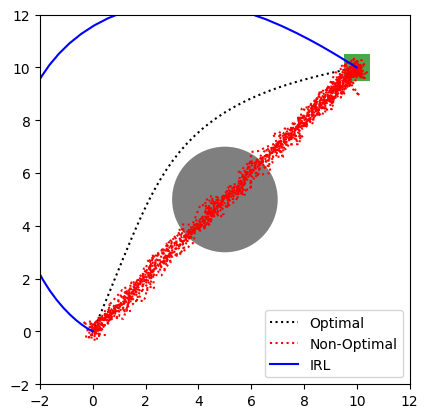

In [52]:
plot_results(xs_optimal, xs_non_optimal_set, xs_output, obs_set, target_high)

processing the animation ... 
... processing done


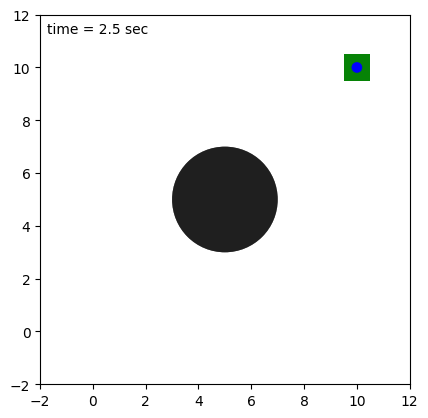

In [53]:
HTML(animatePointMass(xs_output, obs_set, target_high).to_jshtml())

In [54]:
print('Optimal Solver Cost:     ', sqp_opt.cost)
print('Non-Optimal Solver Cost: ', sqp_non_opt.cost)
print('IRL Solver Cost:         ', sqp.cost)

Optimal Solver Cost:      1.011673102842913
Non-Optimal Solver Cost:  1.3201542917364057
IRL Solver Cost:          3.592005683237048e-05
